В этом ноутбуке:
* Первичная обработка данных (обработка пропусков, добавление новых фичей из даты публикации(день недели, месяц, день) и т.п.)
* Работа с текстовыми переменными:
    * Обработка текстов статей (удаление стоп-слов, лишних символов, лемматизация)
    * Обработка хабов и тегов (сортировка по популярности и т.д.)
    * Применение Bag-of-words по хабам
    * Визуализация текстов, сгруппированных по хабам, с помощью "облака слов"
 
Автор: Карнакова Ксения

# Первичная обработка данных
После сбора данных мы получили датасеты, поделенные по номеру публикации (articles/{id}) по 10000 уникальных номеров. Объединим их в один датасет и выполним обработку данных.

In [40]:
import pandas as pd
import numpy as np
import csv, json
import matplotlib.pyplot as plt
from glob import glob
import tqdm
import ast
import re
from collections import Counter
import nltk
from tqdm import tqdm
import string
from pymystem3 import Mystem
import itertools 
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [5]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
directoryPath = "/Users/xenahkar/Downloads/Habr/"
glued_data = pd.DataFrame()
for file_name in glob(directoryPath+'*.csv'):
    x = pd.read_csv(file_name, low_memory=False)
    glued_data = pd.concat([glued_data,x],axis=0)

In [3]:
for file_name in glob(directoryPath+'*.json'):
    x = pd.read_json(file_name)
    glued_data = pd.concat([glued_data,x],axis=0).reset_index(level=0)
    glued_data = glued_data.drop(columns='index')

In [4]:
df = glued_data.copy()
df = df.sort_values(by='id')
df.reset_index(drop= True, inplace= True)

Посмотрим на основную информацию о датафрейме, который создали после объединения всех файлов в единый датафрейм.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172414 entries, 0 to 172413
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               172414 non-null  int64  
 1   is_corporative   172414 non-null  int64  
 2   posttype         172414 non-null  int64  
 3   title            172414 non-null  object 
 4   hubs_pro         172414 non-null  object 
 5   hubs_nopro       172414 non-null  object 
 6   tags             172414 non-null  object 
 7   time_published   172414 non-null  object 
 8   bookmarks        172414 non-null  int64  
 9   comments_count   172414 non-null  int64  
 10  views            172414 non-null  int64  
 11  votes            172414 non-null  int64  
 12  possitive_votes  172414 non-null  int64  
 13  negative_votes   172414 non-null  int64  
 14  reading_time     172414 non-null  int64  
 15  author_name      172414 non-null  object 
 16  author_id        172414 non-null  int6

Пропуски в значениях:

In [6]:
df.isna().sum()

id                  0
is_corporative      0
posttype            0
title               1
hubs_pro            0
hubs_nopro          0
tags                0
time_published      0
bookmarks           0
comments_count      0
views               0
votes               0
possitive_votes     0
negative_votes      0
reading_time        3
lang                0
author_name        69
author_id          69
karma              69
karma_votes        69
rating             69
text                0
dtype: int64

Пропуски в значениях содержатся в столбце **reading_time** (3);
в столбцах **author_id, author_name, karma, karma_votes, rating** (69);
в столбце **title** (1).

В собранных данных содержатся статьи на русском (ru) и английском языке (en). Оставляем только русскоязычные публикации, а затем удаляем столбец "lang", так как в нем во всех строках осталось одно и то же обозначение русского языка (ru).

In [7]:
df.drop(df.loc[df['lang']=='en'].index, inplace=True)

In [8]:
# удалю столбец lang, так как после удаления англоязычных статей он стал неинформативным
df.drop(columns='lang', inplace=True)



Переменная is_corporative принимает два значения: True и False.
Переменная posstype принимает три значения: article, news и megaproject.
Переведу их в категориальный тип.

Для дальнейшей работы оставляем только два типа публикаций: статьи и новости. 
Мегапроекты удаляем, так как обычный пользователь такого типа публикацию разместить не может, а значит, для нашего проекта этот тип публикации не будет полезным. Кроме того, именно в мегапостах содержатся пропуски с информацией об авторе. Удалив статьи типа "мегапроект", мы избавимся от пропусках в столбцах author_id, author_name, karma, karma_votes, rating.

In [9]:
df['is_corporative'].unique()

array([ True, False])

In [10]:
df['posttype'].unique()

array(['article', 'news', 'megaproject'], dtype=object)

In [11]:
# переменную is_corporative переведу в категориальный тип
df['is_corporative'] = df['is_corporative'].astype(int).astype("category")

In [12]:
# переменную posttype  переведу в категориальный тип
df['posttype'] = df['posttype'].replace({'article': 0, 'news': 1, 'megaproject': 2}).astype("category")

In [13]:
# удаляю мегапосты
df.drop(df.loc[df['posttype']==2].index, inplace=True)

В столбце **reading_time** имеется три пропущенных значения, заменим эти пропуски на медиану времени чтения публикаций.

In [14]:
df['reading_time'] = df['reading_time'].fillna(df['reading_time'].median())

В заголовке статьи есть одно пропущенное значение. Внимательнее посмотрев на эту публикацию, становится понятно, что эта статья содержит заголовок с текстом "NULL", который записался как NaN. Заменим этот пропуск обратно на ""NULL"" (в кавычках).

Добавим день недели как новую колонку, так ранее было определено влияние дня недели публикации на рейтинг публикации, количество просмотров и т.д.

In [16]:
df['title'] = df['title'].fillna('"NULL"')

In [206]:
df['time_published'] = pd.to_datetime(df['time_published'], format='ISO8601')

In [208]:
# добавлю день недели как новую колонку, выведу их количество
df['weekday'] = pd.to_datetime(df['time_published']).dt.weekday
# добавлю год как новую колонку, выведу их количество
df['year'] = pd.to_datetime(df['time_published']).dt.year
# добавлю месяц как новую колонку, выведу их количество
df['month'] = pd.to_datetime(df['time_published']).dt.month
# добавлю день как новую колонку, выведу их количество
df['day'] = pd.to_datetime(df['time_published']).dt.day
# добавлю время публикации как новую колонку
df['time'] = pd.to_datetime(df['time_published']).dt.time

Перейдем к обработке текста.

# Работа с текстовыми переменными
## Очистка данных и обработка текста

В столбце **text** помимо текста статьи содержатся теги (например img, a, p, code) и разделители (\n, \t, \xa0 и т.д.), которые нам необходимо убрать из текста.



В тексте содержатся различные грамматические формы одного и того же слова. Для приведения слов к одной форме будем применять лемматизацию. Для этой задачи воспользуемся библиотекой от Яндекса - pymystem3. Кроме этого, удалим стоп-слова из наших данных, так как в процессе применения машинного обучения они будут добавлять шум и влиять на качество. Для удаления стоп-слов применим библиотеку nltk. Мы оставим только слова, удалив различные небуквенные символы и цифры. В конечном итоге мы получим разбитый на токены текст.


Далее будем применть "Bag-of-words" и TF-IDF.

In [29]:
stopwords_russian = stopwords.words('russian')

In [29]:
df['preprocess_text'] = str()

In [30]:
def preprocess_text(text):
    '''
    Предобрабатывает текст
    удаляет теги и разделители
    '''
    text = re.sub(r'<[^>]*>', " ", text)
    text = re.sub(r'[\s\n\t]', " ", text)
    text = re.sub(r'\s{2,}', " ", text)
    return text

In [31]:
for i in tqdm(df.index):
    df['preprocess_text'][i] = preprocess_text(df['text'][i])

100%|██████████████████████████████████| 172414/172414 [03:17<00:00, 872.94it/s]


In [216]:
df.drop(columns='text', inplace=True)

В столбце с текстом статьи text после удаления тегов html обнаружилось интересное: есть пять статей от одного автора, текст и заголовок которых заменен на "Статья удалена". Удалим их из датасета.

In [9]:
df['preprocess_text'].describe()

count               172414
unique              172389
top        Статья удалена 
freq                     5
Name: preprocess_text, dtype: object

In [10]:
# посмотрим id и автора этих статей 
for i in range(len(df)):
    if 'Статья удалена' in df['preprocess_text'][i]:
        print(i)
        print(f'article {df.id[i]}, author {df.author_name[i]}')

17122
article 352732, author lynxp9
17999
article 354860, author lynxp9
18000
article 354862, author lynxp9
46011
article 421985, author lynxp9
51361
article 434810, author lynxp9


In [11]:
df = df[df['author_name'] != 'lynxp9']

In [39]:
df.to_csv('Habr_dataset.csv', sep=',', index=False)

Теперь выполним лемматизацию текста.

In [30]:
mystem = Mystem()

In [ ]:
df['lemmatized_text'] = str()

In [31]:
def lemmatize_text(text):
    '''
      Лемматизация текста
      если слова нет в списке стоп-слов,
      слово длиннее двух символов
      состоит только из букв/ только из букв и есть тире
    '''
    text_tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in text_tokens if token not in stopwords_russian\
              and len(token) > 2 \
              and (token.isalpha() or ((token.split('-')[0]).isalpha()))]
    return tokens
    

In [43]:
df_iterator = pd.read_csv('Habr_dataset.csv', chunksize=10000)
new_chunk = 0
for df in df_iterator:
    print('Chunk =', new_chunk)
    df['lemmatized_text'] = str()
    df['lemmatized_text'] = df['preprocess_text'].parallel_apply(lemmatize_text)
    if new_chunk == 0:
        df.to_csv('Habr_lemmatized.csv', sep=',', index=False)
    else:
        df.to_csv('Habr_lemmatized.csv', mode='a', header=False, sep=',', index=False)
    new_chunk+=1

Chunk = 0


Chunk = 1


Chunk = 2


Chunk = 3


Chunk = 4


Chunk = 5


Chunk = 6


Chunk = 7


In [3]:
df = pd.read_csv('Habr_lemmatized.csv')

## Хабы
В спарсенных данных содержится избыточная информация о хабах, оставим только alias хабов.

In [364]:
ast.literal_eval(df.hubs_pro[0])

[{'id': '221',
  'alias': 'sys_admin',
  'type': 'collective',
  'title': 'System administration',
  'titleHtml': 'System administration',
  'isProfiled': True,
  'relatedData': None},
 {'id': '19197',
  'alias': 'dwh',
  'type': 'collective',
  'title': 'Data storage',
  'titleHtml': 'Data storage',
  'isProfiled': True,
  'relatedData': None},
 {'id': '20788',
  'alias': 'devops',
  'type': 'collective',
  'title': 'DevOps',
  'titleHtml': 'DevOps',
  'isProfiled': True,
  'relatedData': None}]

In [198]:
# профильные хабы
df['hubs'] = str()
pd.options.mode.chained_assignment = None
for i in tqdm(df.index):
    if len(df.hubs_pro[i])>2:
        my_dict = ast.literal_eval(df.hubs_pro[i][1:-1])
        if type(my_dict) is tuple:
            hublist = []
            for j in range(len(my_dict)):
                hublist.append(my_dict[j]['alias'])
            df['hubs'][i] = ','.join(hublist)
        if type(my_dict) is dict:
            df['hubs'][i] = my_dict['alias']

100%|█████████████████████████████████| 172409/172409 [00:33<00:00, 5189.02it/s]


In [202]:
# непрофильные хабы
df['hubs_additional'] = str()
for i in tqdm(df.index):
    if len(df.hubs_nopro[i])>2:
        my_dict = ast.literal_eval(df.hubs_nopro[i][1:-1])
        if type(my_dict) is tuple:
            hublist = []
            for j in range(len(my_dict)):
                hublist.append(my_dict[j]['alias'])
            df['hubs_additional'][i] = ','.join(hublist)
        if type(my_dict) is dict:
            df['hubs_additional'][i] = my_dict['alias']

100%|█████████████████████████████████| 172409/172409 [00:45<00:00, 3815.49it/s]


In [214]:
df.drop(columns='hubs_pro', inplace=True)

In [215]:
df.drop(columns='hubs_nopro', inplace=True)

In [4]:
df.hubs = df.hubs.replace(np.nan, 'NaN')
df.hubs_additional = df.hubs_additional.replace(np.nan,'NaN')

Для профильных хабов (hubs) попробую применить MultiLabelBinarizer.

In [5]:
h_list = []
for i in df.index:
    h_list.append(tuple(df.hubs[i].split(",")))

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

mlb_hubs = mlb.fit_transform(h_list)

# уникальные хабы
print(list(mlb.classes_))

['1C', '3d_graphics', 'AJAX', 'Atlassian', 'Hadoop', 'IPFS', 'NaN', 'Sailfish_dev', 'UEFI', 'Xamarin', 'accessibility', 'action_script', 'agile', 'algorithms', 'analysis_design', 'android_dev', 'angular', 'animation', 'apache', 'api', 'apps_design', 'arduino', 'arvrdev', 'asp', 'assembler', 'asterisk', 'aws', 'azure', 'backup', 'bigdata', 'billing', 'bitrix', 'brainfuck', 'bughunters', 'build_automation', 'business_models', 'c', 'cad_cam', 'canvas', 'cgi', 'circuit-design', 'cisconetworks', 'client_side_optimization', 'clojure', 'cloud_computing', 'cloud_services', 'cms', 'cobol', 'cocoa', 'codeigniter', 'coffeescript', 'community_management', 'compilers', 'complete_code', 'contentmarketing', 'context', 'controllers', 'conversion', 'cpp', 'crazydev', 'creative_commons', 'crm', 'crypto', 'csharp', 'css', 'ctf', 'cvs', 'd', 'dart', 'data_compression', 'data_engineering', 'data_mining', 'data_recovery', 'data_visualization', 'data_warehouse', 'db_admins', 'debug', 'delphi', 'desktop_envir

In [7]:
# количество профильных хабов 
len(mlb.classes_)

322

In [8]:
res = pd.DataFrame(mlb_hubs, columns=mlb.classes_)

In [9]:
res.drop(columns='NaN', inplace=True)

In [10]:
res

,1C,3d_graphics,AJAX,Atlassian,Hadoop,IPFS,Sailfish_dev,UEFI,Xamarin,accessibility,...,wireless,wordpress,wp_dev,xcode,xml,xslt,yandex_api,yii,zend_framework,zig
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Посмотрю, какие хабы чаще всего использовались.

In [11]:
popular_hubs = dict()
for col in res.columns:
    popular_hubs[col] = res[col].value_counts()[1]

In [12]:
popular_hubs = sorted(popular_hubs.items(), key=lambda x:x[1], reverse=True)
popular_hubs

[('infosecurity', 13694),
 ('programming', 12993),
 ('it-infrastructure', 7377),
 ('machine_learning', 6512),
 ('webdev', 6094),
 ('javascript', 5572),
 ('python', 5450),
 ('sys_admin', 5314),
 ('hr_management', 4976),
 ('open_source', 4602),
 ('gamedev', 4508),
 ('pm', 4354),
 ('mobile_dev', 4238),
 ('cloud_services', 3695),
 ('network_technologies', 3566),
 ('devops', 3505),
 ('algorithms', 3448),
 ('productpm', 3330),
 ('dev_management', 3265),
 ('analysis_design', 3260),
 ('java', 3223),
 ('android_dev', 3188),
 ('electronics', 3164),
 ('ios_dev', 2772),
 ('research', 2687),
 ('bigdata', 2626),
 ('maths', 2602),
 ('s_admin', 2492),
 ('it_testing', 2389),
 ('cpp', 2324),
 ('hi', 2238),
 ('dwh', 2090),
 ('net', 2090),
 ('web_testing', 1910),
 ('csharp', 1898),
 ('php', 1741),
 ('linux', 1673),
 ('image_processing', 1635),
 ('controllers', 1627),
 ('ui', 1579),
 ('business_models', 1565),
 ('api', 1519),
 ('linux_dev', 1469),
 ('kubernetes', 1424),
 ('nix', 1415),
 ('ecommerce', 1396)

In [13]:
hubs_dict = dict((x, y) for x, y in popular_hubs[:30])

dict_keys(['infosecurity', 'programming', 'it-infrastructure', 'machine_learning', 'webdev', 'javascript', 'python', 'sys_admin', 'hr_management', 'open_source', 'gamedev', 'pm', 'mobile_dev', 'cloud_services', 'network_technologies', 'devops', 'algorithms', 'productpm', 'dev_management', 'analysis_design', 'java', 'android_dev', 'electronics', 'ios_dev', 'research', 'bigdata', 'maths', 's_admin', 'it_testing', 'cpp'])

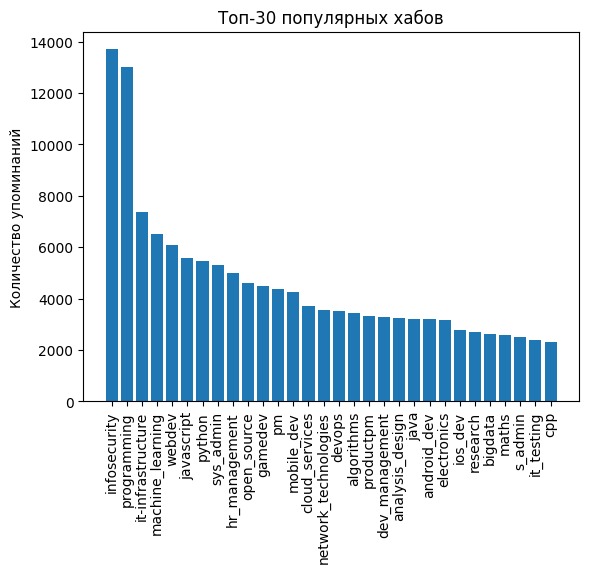

In [421]:
import matplotlib.pyplot as plt 


plt.bar(hubs_dict.keys(), hubs_dict.values())
plt.xticks(rotation=90)
plt.ylabel('Количество упоминаний')
plt.title('Топ-30 популярных хабов')
plt.show()

## Теги

In [376]:
t_list = []
for i in df.index:
    t_list.extend(df.tags[i].split(","))

In [424]:
from collections import Counter
popular_tags = Counter(t_list)

In [434]:
popular_tags = sorted(dict(popular_tags).items(), key=lambda x:x[1], reverse=True)
popular_tags

[('python', 3662),
 ('разработка', 3091),
 ('javascript', 2891),
 ('программирование', 2818),
 ('искусственный интеллект', 2743),
 ('информационная безопасность', 2615),
 ('машинное обучение', 2476),
 ('java', 2346),
 ('игры', 2202),
 ('android', 2171),
 ('apple', 2165),
 ('linux', 1923),
 ('google', 1903),
 ('microsoft', 1803),
 ('тестирование', 1772),
 ('devops', 1661),
 ('космос', 1535),
 ('open source', 1478),
 ('ios', 1455),
 ('проблема', 1450),
 ('безопасность', 1427),
 ('гаджеты', 1370),
 ('обучение', 1286),
 ('kubernetes', 1262),
 ('россия', 1260),
 ('дайджест', 1234),
 ('смартфоны', 1201),
 ('php', 1198),
 ('react', 1193),
 ('нейросети', 1136),
 ('яндекс', 1132),
 ('c++', 1125),
 ('разработка игр', 1097),
 ('data science', 1051),
 ('карьера', 1050),
 ('сша', 1045),
 ('конференция', 1036),
 ('финансы', 1021),
 ('алгоритмы', 1014),
 ('postgresql', 1005),
 ('китай', 984),
 ('machine learning', 980),
 ('роботы', 960),
 ('Microsoft', 955),
 ('дизайн', 947),
 ('аналитика', 928),
 ('

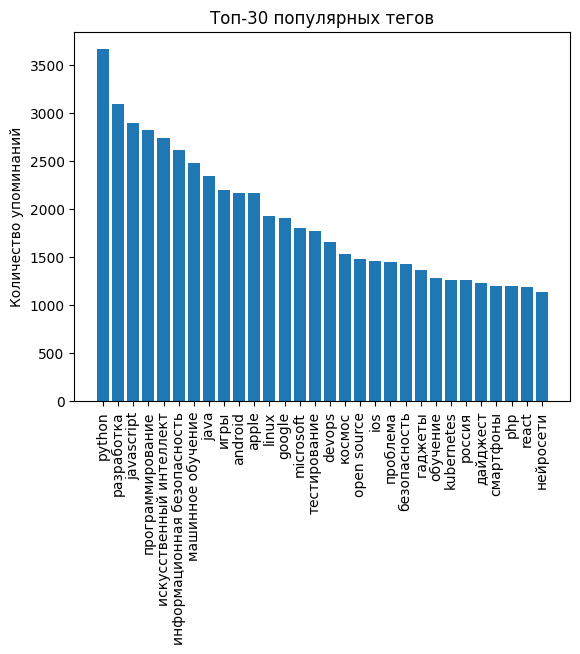

In [435]:
tags_dict = dict((x, y) for x, y in popular_tags[:30])
plt.bar(tags_dict.keys(), tags_dict.values())
plt.xticks(rotation=90)
plt.ylabel('Количество упоминаний')
plt.title('Топ-30 популярных тегов')
plt.show()

In [108]:
df

,id,is_corporative,posttype,title,tags,time_published,bookmarks,comments_count,views,votes,...,rating,preprocess_text,hubs,hubs_additional,year,month,day,time,weekday,lemmatized_text
0,310000,1,0,Как мы неделю чинили compaction в Cassandra,"cassandra,nosql,troubleshooting",2016-09-17 06:11:00+00:00,45,13,11917,41,...,0.0,Основным хранилищем метрик у нас является cas...,"sys_admin,dwh,devops",okmeter,2016,9,17,06:11:00,5,основной хранилище метрика являться cassandra ...
1,310002,1,0,Войны гипервизоров: To be continued,"облачные вычисления,виртуализация,хостинг,гипе...",2016-09-15 07:56:08+00:00,19,23,7342,0,...,62.3,"Войны гипервизоров — дело непрерывное, и, нав...","it-infrastructure,virtualization,cloud_computing","cloud4y,hosting",2016,9,15,07:56:08,3,война гипервизор дело непрерывный наверное дей...
2,310006,0,0,AdBlock Plus совершил новый виток в истории «п...,"adblock plus,блокировка рекламы,медийная рекла...",2016-09-14 14:26:49+00:00,35,83,44608,36,...,0.0,Один из крупнейших в мире блокировщиков рекла...,"web_monetization,mobile_monetization,display_a...",NaN,2016,9,14,14:26:49,2,крупный мир блокировщик реклама adblock plus п...
3,310008,1,0,Миф о незрелости мобильных NFC технологий,"Gemalto,nfc,мобильные приложения,мобильный пла...",2016-09-15 08:02:54+00:00,12,8,6343,9,...,0.0,Современные NFC-технологии в их нынешнем виде...,"infosecurity,pay_system,ecommerce_development",gemaltorussia,2016,9,15,08:02:54,3,современный nfc технология нынешний вид появля...
4,310014,1,0,OpenJDK: Project Panama,"joker2016,jokerconf,java,jvm,panama",2016-09-15 06:30:51+00:00,50,12,14040,34,...,0.0,Два года назад в OpenJDK был создан новый про...,"programming,java",jugru,2016,9,15,06:30:51,3,год назад openjdk создавать новый проект кодов...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172404,773134,0,1,Engadget выпустил обзор Steam Deck OLED,"steam deck oled,steam deck,valve,портативные к...",2023-11-10 11:46:43+00:00,0,0,130,3,...,119.0,Техноблог Engadget представил обзор портативн...,NaN,"games,gadgets",2023,11,10,11:46:43,4,техноблог engadget представлять обзор портатив...
172405,773138,0,1,ЦБ планирует внедрить стандарт безопасности оп...,"банк россии,цб,qr-коды,информационная безопасн...",2023-11-10 11:49:58+00:00,0,0,111,3,...,142.7,"Банк России разрабатывает стандарт, который п...","pay_system,infosecurity",finance,2023,11,10,11:49:58,4,банк россия разрабатывать стандарт который поз...
172406,773140,0,0,Отчёт о походе на выставку ретроконсолей от «Я...,"электроника,электроника-25,ретроконсоли,game&a...",2023-11-10 11:52:49+00:00,0,0,119,6,...,142.5,Информационная служба Хабра посетила выставку...,NaN,"games,history,wearable_electronics",2023,11,10,11:52:49,4,информационный служба хабрый посещать выставка...
172407,773142,1,0,Разработка через тестирование. Совместное испо...,"разработка через тестирование,mockito,junit",2023-11-10 12:04:46+00:00,0,0,19,0,...,19.0,"Привет, Хабр! На связи участница профессионал...","it_testing,tdd",sberbank,2023,11,10,12:04:46,4,привет хабр связь участница профессиональный с...


## Bag-of-words
Предварительно сгруппировав тексты статей по хабам, создам для каждого хаба "мешок слов".


In [41]:
hub_names = list(x for x, y in popular_hubs)

In [132]:
from collections import Counter

In [136]:
df_hub_bag = pd.DataFrame(columns=['hub', 'texts', 'bag_of_words'])

def words_by_hub(hub):
    df_temp = df[(df['hubs'].str.contains(hub)) == True]
    list_of_texts = list(df_temp['lemmatized_text'])
    str_of_texts = " ".join(list_of_texts)
    return str_of_texts

In [137]:
for hub in tqdm(hub_names):
    txt = words_by_hub(hub)
    list_text = txt.split(' ')
    counted_words = Counter(list_text)

    df_hub_bag.loc[len(df_hub_bag)] = {
        'hub': hub,
        'texts': txt,
        'bag_of_words': counted_words
    }

100%|█████████████████████████████████████████| 321/321 [14:02<00:00,  2.62s/it]


In [144]:
df_hub_bag

,hub,texts,bag_of_words
0,infosecurity,современный nfc технология нынешний вид появля...,"{'современный': 4131, 'nfc': 383, 'технология'..."
1,programming,год назад openjdk создавать новый проект кодов...,"{'год': 25154, 'назад': 3673, 'openjdk': 360, ..."
2,it-infrastructure,война гипервизор дело непрерывный наверное дей...,"{'война': 221, 'гипервизор': 886, 'дело': 5228..."
3,machine_learning,пост подготовить материал выступление констант...,"{'пост': 2344, 'подготовить': 1295, 'материал'..."
4,webdev,предисловие статья весь возможный связанный ти...,"{'предисловие': 53, 'статья': 10463, 'весь': 3..."
...,...,...,...
316,silverlight,октябрь майкрософт прекращать поддержка silver...,"{'октябрь': 1, 'майкрософт': 1, 'прекращать': ..."
317,coffeescript,текстовый редактор также средство разработка с...,"{'текстовый': 3, 'редактор': 13, 'также': 5, '..."
318,phalcon,время идти прогресс приносить свой плод каждый...,"{'время': 1, 'идти': 1, 'прогресс': 1, 'принос..."
319,twisted,картинка официальный сайт buildbot несложно до...,"{'картинка': 3, 'официальный': 6, 'сайт': 1, '..."


In [143]:
df_hub_bag[['hub', 'bag_of_words']].to_csv('bag_of_words_by_hubs.csv', sep=',', index=False)

Для **10 самых популярных хабов** визуализую текст статей с помощью "облака слов" из библиотеки WordCloud и сохраню их в png.

In [219]:
#! pip3 install wordcloud
# ! pip3 install stop_words

In [140]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from stop_words import get_stop_words

STOPWORDS_RU = get_stop_words('russian')

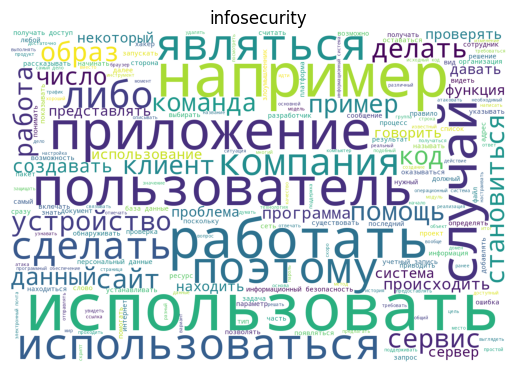

In [142]:
# для начала создам облако слов для самого частовстречающегося хаба (infosecurity)
text = df_hub_bag['texts'][0]
name = df_hub_bag['hub'][0]
wordcloud = WordCloud(
    width = 1500, 
    height = 1000,
    background_color ='white',
    stopwords = STOPWORDS_RU).generate(text)
wordcloud.to_file(name+'.png')
plt.imshow(wordcloud)
plt.title(name)
plt.axis('off')
plt.show()

In [147]:
# сохраню остальные облака слов для 10 самых популярных хабов
for i in tqdm(range(1,10)):
    text = df_hub_bag['texts'][i]
    name = df_hub_bag['hub'][i]
    wordcloud = WordCloud(
        width = 1500, 
        height = 1000,
        background_color ='white',
        stopwords = STOPWORDS_RU).generate(text)
    wordcloud.to_file(name+'.png')

100%|█████████████████████████████████████████████| 9/9 [09:28<00:00, 63.11s/it]
